In [1]:
%pylab inline 
import pandas as pd 
import joblib

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the selected variant indices
selected_variant_df = joblib.load('new_selected_variants_df.pkl')

# Use these indices to filter future VCF data
#filtered_vcf_data = vcf_data.iloc[selected_variant_indices]  # Assuming vcf_data is your future data

In [3]:
bed_df = selected_variant_df[['#CHROM', 'POS', 'REF', 'ALT']].copy()

# Adjust the POS column for BED's 0-based start (subtract 1)
bed_df['start'] = bed_df['POS'] - 1
bed_df['end'] = bed_df['POS']

# Rearrange columns for BED format (chromosome, start, end, followed by REF and ALT)
bed_df = bed_df[['#CHROM', 'start', 'end', 'REF', 'ALT']]

# Write the dataframe to a BED file
bed_df.to_csv('new_SVM_hg38.bed', sep='\t', header=False, index=False)

print("BED file has been created: selected_variant.bed")

BED file has been created: selected_variant.bed


In [4]:
bed_df.reset_index(drop=True, inplace=True)

In [5]:
bed_df[bed_df['start'].isin([12598032, 12598050, 147454703, 38380229, 54542178, 54316208])]#.index

,#CHROM,start,end,REF,ALT
20,chr1,12598032,12598033,C,T
21,chr1,12598050,12598051,A,G
159,chr1,147454703,147454704,C,G
4110,chr17,38380229,38380230,A,G
4300,chr18,54542178,54542179,T,G
4431,chr19,54316208,54316209,T,G


In [6]:
#Import lift over 
hg19_bed = pd.read_csv('hglft_genome_1055d_a8d020.bed', sep ='\t', header = None)

In [7]:
hg19_bed.columns = ['#CHROM', 'start', 'end' ,'REF', 'ALT']

In [8]:
missing_indices = [20, 21, 159, 4110, 4300, 4431]

# Create a filler row
filler_row = {
    '#CHROM': '#Deleted in new',
    'start': None,
    'end': None,
    'REF': None,
    'ALT': None, 
}

# Insert fillers at the correct positions while maintaining the index structure
for idx in missing_indices:
    # Insert the filler row into hg19_bed at the specified index
    hg19_bed = pd.concat([hg19_bed.iloc[:idx], pd.DataFrame([filler_row]), hg19_bed.iloc[idx:]]).reset_index(drop=True)



In [9]:
hg19_bed['ALT'] = bed_df['ALT']

In [10]:
# Save the modified hg19_bed dataframe to a BED file
hg19_bed.to_csv('new_hg19_bed_SVM_index.bed', sep='\t', header=False, index=False)

print("BED file with fillers has been created: hg19_bed_with_fillers.bed")

BED file with fillers has been created: hg19_bed_with_fillers.bed


In [11]:
import os

# Directory containing the VCF files
vcf_directory = 'VCF/'

# Get a list of all files in the directory
vcf_files = os.listdir(vcf_directory)

In [21]:
vcf_files = [i for i in vcf_files if '.vcf' in i]
vcf_files = [i for i in vcf_files if '.idx' not in i]

In [13]:
hg19_bed.columns = ['#Chr', 'Start', 'End', 'Ref', 'Alt']

In [18]:
def process_single_vcf_and_generate_df(vcf_file, exome_df):
    # Extract the sample name from the VCF filename (without extension)
    sample_name = vcf_file.split('.')[0].split('/')[-1]
    
    
    
    # Initialize the DataFrame with the exome data and add a new column for the genotype
    sample_df = pd.DataFrame(0, index=exome_df.index, columns=['#Chr', 'Start', 'End', sample_name])
    sample_df[['#Chr', 'Start', 'End']] = exome_df[['#Chr', 'Start', 'End']]
    
    # Process the VCF file
    #vcf_in = pysam.VariantFile(vcf_file)

    
    # Re-open the VCF file to start processing from the beginning
    vcf_in = pysam.VariantFile(vcf_file)
    
    for record in vcf_in:
        chrom = record.chrom
        pos = record.pos
        sample = list(record.samples.keys())[0]  # Assuming only one sample per VCF
        genotype = record.samples[sample]['GT']
        
        # Convert genotype to 0, 1, or 2
        if genotype == (0, 0):
            genotype_value = 0
        elif genotype in [(0, 1), (1, 0)]:
            genotype_value = 1
        elif genotype == (1, 1):
            genotype_value = 2
        else:
            genotype_value = 0  # In case of missing data, assume 0

        # Check if the current VCF position is in the exome data
        #matching_rows = (exome_df['#Chr'] == chrom) & (exome_df['Start'] == pos)
        matching_rows = (exome_df['#Chr'] == chrom) & (exome_df['End'] == pos) & (exome_df['Alt'] == record.alts[0]) 
        if matching_rows.any():
            index = exome_df[matching_rows].index
            sample_df.loc[index, sample_name] = genotype_value
    
    # Drop the position columns if you don't need them in the final DataFrame
    sample_df = sample_df.drop(columns=['#Chr', 'Start', 'End'])
    
    return sample_df

In [114]:
#exome_file = 'SNP_AIMS.txt'  # Replace with your filtered exome data file path
#exome_df = pd.read_csv(exome_file, sep='\t')

In [19]:
import pysam

In [22]:
#exome_file = 'SNP_AIMS.txt'  # Replace with your filtered exome data file path
#exome_df = pd.read_csv(exome_file, sep='\t')
exome_df = hg19_bed.copy()


vcf_file = 'VCF/C7661059.sorted.bam.vcf'  # Replace with your VCF file path
# Process the VCF and get the DataFrame
sample_df = process_single_vcf_and_generate_df(vcf_file, exome_df)
sample_df.to_csv('Sample_SNP/C7661059.txt', sep = '\t')

cnt = 0 
master_df = sample_df.copy()
for vcf in vcf_files[1:]:
    a = time.time()
    vcf_file = 'VCF/'+vcf
    sample_df = process_single_vcf_and_generate_df(vcf_file, exome_df)
    master_df = pd.concat([master_df,sample_df], axis=1) #I think this approach was taking too long 
    if sample_df is not None:
        sample_df.to_csv(f'Sample_SNP/{vcf.split('.')[0]}.txt', sep = '\t')
        print(cnt, time.time()-a)
        #print()
        cnt+=1

master_df = master_df.loc[:, ~master_df.columns.duplicated()]
master_df.to_csv('Sample_SNP_array.csv') 

print('Done')

0 3.6389288902282715
1 3.5018808841705322
2 3.485704183578491
3 3.419666290283203
4 3.485233783721924
5 3.540996789932251
6 3.5529532432556152
7 3.5055060386657715
8 3.554649829864502
9 4.007381916046143
10 3.7497432231903076
11 3.609745979309082
12 3.5796101093292236
13 3.5862810611724854
14 3.5867559909820557
15 3.7058827877044678
16 3.7003116607666016
17 3.5615878105163574
18 3.577542781829834
19 2.998335123062134
20 3.7182281017303467
21 3.915099859237671
22 3.577235221862793
23 3.8169260025024414
24 3.483322858810425
25 3.5620810985565186
26 3.521209716796875
27 3.460482120513916
28 3.3985509872436523
29 3.8484153747558594
30 3.659426212310791
31 3.4832582473754883
32 3.5159778594970703
33 3.5602307319641113
34 3.784456968307495
35 3.5867202281951904
36 3.8372459411621094
37 3.596019983291626
38 3.6263959407806396
39 3.56188702583313
40 3.749345064163208
41 3.8791768550872803
42 3.6367087364196777
43 3.5627620220184326
44 3.553948163986206
45 3.3156590461730957
46 3.47528982162475

370 3.5676231384277344
371 3.541435956954956
372 3.5359270572662354
373 3.527224063873291
374 3.5613341331481934
375 3.8782169818878174
376 3.4364771842956543
377 3.432716131210327
378 3.491339921951294
379 3.424860954284668
380 3.4672138690948486
381 3.4854190349578857
382 3.4530041217803955
383 3.4043338298797607
384 3.4596800804138184
385 3.4665310382843018
386 3.364755868911743
387 3.2737882137298584
388 3.508005142211914
389 3.2123351097106934
390 3.4101340770721436
391 3.349360942840576
392 3.367480993270874
393 3.3635799884796143
394 3.45661997795105
395 3.4595282077789307
396 3.5046889781951904
397 3.328453779220581
398 3.4580330848693848
399 3.436633825302124
400 3.252331018447876
401 3.3419530391693115
402 3.516380786895752
403 3.431410074234009
404 3.4558112621307373
405 3.416626214981079
406 3.5171427726745605
407 3.349757194519043
408 3.3375651836395264
409 3.4043891429901123
410 3.4182090759277344
411 3.4582700729370117
412 3.4389219284057617
413 3.4450690746307373
414 3.

735 3.3918063640594482
736 3.840744972229004
737 3.5390799045562744
738 3.6672677993774414
739 3.475950002670288
740 3.5902137756347656
741 3.0811219215393066
742 3.560865879058838
743 3.535240888595581
744 3.481755018234253
745 3.3823130130767822
746 3.535461187362671
747 3.4961819648742676
748 3.3782191276550293
749 3.4167070388793945
750 3.4353909492492676
751 3.52982497215271
752 3.4083290100097656
753 3.4088969230651855
754 3.459280014038086
755 3.3959221839904785
756 3.625891923904419
757 3.549909830093384
758 4.347830057144165
759 3.4713971614837646
760 3.3922040462493896
761 3.4892160892486572
762 3.368957042694092
763 3.5093371868133545
764 3.3954110145568848
765 3.492493152618408
766 3.3066980838775635
767 3.6349599361419678
768 3.494314193725586
769 3.5177409648895264
770 3.5040030479431152
771 3.3606598377227783
772 3.508593797683716
773 3.424440860748291
774 3.4750189781188965
775 3.3881640434265137
776 3.3871421813964844
777 3.406385898590088
778 3.645392894744873
779 3.4

In [ ]:
#Here

In [24]:
loaded_svm_model = joblib.load('new_svm_model.pkl')
print("SVM model loaded successfully")

# Load the saved selected features (if feature selection was applied)
selected_features = joblib.load('new_selected_variants.pkl')
print("Selected features loaded successfully")



SVM model loaded successfully
Selected features loaded successfully


In [25]:
X_test = array(master_df)

In [26]:
X_test = X_test.T

In [27]:
# Apply the feature selection when making predictions
X_test_selected = X_test#[:, selected_features]  # Use the saved feature indices to filter the test data
y_pred_svm = loaded_svm_model.predict(X_test_selected)

In [28]:
pd.Series(y_pred_svm).value_counts()

EUR    619
EAS    139
AFR     25
AMR      5
SAS      2
Name: count, dtype: int64

In [29]:
X_test_selected = X_test#[:, selected_features]  # Use the saved feature indices to filter the test data
y_pred_proba = loaded_svm_model.predict_proba(X_test_selected)

In [30]:
preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)


In [31]:
preds_df['predictions'].value_counts()

predictions
NFE    598
EAS    140
AFR     52
Name: count, dtype: int64

In [37]:
clf.classes_ = array(['AFR', 'AMR', 'EAS', 'EUR', 'SAS'], dtype='<U3')

In [49]:
y_predictions = []
y1 = []
y2 = []
second_pred = []
# Assuming y_test contains the true ethnicity labels for the test samples
# y_test should be aligned with the indices of X_test

# Train an SVM model with probability=True to enable probability predictions
#svc = SVC(kernel='rbf', probability=True, random_state=42)
#svc.fit(X_train, y_train)

# Predict probabilities
y_proba = loaded_svm_model.predict_proba(X_test_selected)


# Predict probabilities using Random Forest


# Iterate through each sample's probabilities and show the true ethnicity label
for i, probs in enumerate(y_proba):
    sorted_indices = probs.argsort()[::-1]  # Sort in descending order
    top_1 = sorted_indices[0]  # Index of the primary ethnicity
    top_2 = sorted_indices[1]  # Index of the second highest ethnicity (admixture likelihood)
    
    # Get the true ethnicity from y_test
    #true_ethnicity = y_test[i]
    
    # Apply the rule: If primary ethnicity is EUR and prob < 0.60, and second highest is ASJ with prob > 0.30
    if (clf.classes_[top_1] == 'EUR' and probs[top_1] < 0.50) and (clf.classes_[top_2] == 'ASJ' and probs[top_2] > 0.30):
        predicted_ethnicity = 'ASJ'
        #print('FREEZE')
        #print(f"Sample {i+1}: True Ethnicity: {true_ethnicity}")
        print(f"Rule applied: Changed predicted ethnicity from EUR to ASJ")
    else:
        predicted_ethnicity = clf.classes_[top_1]
        #print(f"Sample {i+1}: True Ethnicity: {true_ethnicity}")
        print(f"Primary Predicted Ethnicity: {predicted_ethnicity} with probability {probs[top_1]:.4f}")

    print(f"Possible Admixture: {clf.classes_[top_2]} with probability {probs[top_2]:.4f}")
    print("-" * 30)
    y_predictions.append(predicted_ethnicity)
    y1.append(probs[top_1])
    y2.append(probs[top_2])
    second_pred.append(clf.classes_[top_2])

Primary Predicted Ethnicity: EAS with probability 0.9784
Possible Admixture: AMR with probability 0.0116
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9476
Possible Admixture: AMR with probability 0.0229
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9812
Possible Admixture: SAS with probability 0.0079
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9450
Possible Admixture: SAS with probability 0.0222
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9631
Possible Admixture: AMR with probability 0.0179
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.7751
Possible Admixture: SAS with probability 0.1582
------------------------------
Primary Predicted Ethnicity: EAS with probability 0.9611
Possible Admixture: SAS with probability 0.0128
------------------------------
Primary Predicted Ethnicity: EUR with probabilit

In [1]:
pd.Series(y_predictions).value_counts()


NameError: name 'pd' is not defined

In [58]:
svm_preds = pd.DataFrame()
svm_preds['Sample'] = master_df.columns
svm_preds['Pred'] = y_predictions
svm_preds['Primary_Perc'] = y1
svm_preds['Second'] = second_pred
svm_preds['Second_Perc'] = y2

In [59]:
svm_preds[svm_preds['Sample']=='C7256776']

,Sample,Pred,Primary_Perc,Second,Second_Perc
359,C7256776,SAS,0.763564,AMR,0.103364


In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
#RERun with original PCA values - from all SNPS
master_df = pd.read_csv('SNP_AIMS_Sample_SNP_array.csv',  index_col=0) 

In [79]:

# You can choose to use the original or binarized data
# For example, if you want to use the binarized data:
# master_df = master_df.applymap(lambda x: 1 if x == 2 else x)

# Standardize the data (important for PCA)
# If you have not already standardized it, you can do it as follows
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(master_df.T)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
principal_components = pca.fit_transform(standardized_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=master_df.columns)


In [80]:

preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)

# Assuming preds_df and pca_df are already defined

# Extract sample names by removing the ".sorted.bam.vcf" or similar extensions
preds_df['Sample'] = preds_df['VCF'].str.replace('.sorted.bam.vcf', '').str.replace('.vcf', '')


In [81]:
svm_preds.columns

Index(['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc'], dtype='object')

In [82]:
#Import predictions
#preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)

# Assuming preds_df and pca_df are already defined

# Extract sample names by removing the ".sorted.bam.vcf" or similar extensions
#preds_df['Sample'] = preds_df['VCF'].str.replace('.sorted.bam.vcf', '').str.replace('.vcf', '')


# Set the index of pca_df to the sample names (if not already done)
pca_df.index.name = 'Sample'
pca_df.reset_index(inplace=True)

# Merge the two DataFrames on the 'Sample' column
merged_df = pd.merge(pca_df, svm_preds, on='Sample', how='left')





In [83]:
list(svm_preds.columns)

['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc']

In [86]:
import plotly.express as px

# Assuming you have merged_df from the previous steps

# Create the interactive plot with Plotly
fig = px.scatter(
    merged_df,
    x='PC1',
    y='PC2',
    color='Pred',  # Color points by their predicted labels
    hover_name='Sample',  # Show the sample ID on hover
    hover_data=['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc'], 
    #labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'Second':'Secondary Ancestry'},
    title='PCA of Genotype Data with Interactive Labels'
)

# Highlight specific IDs by increasing their marker size
#highlight_ids = ['C0953478_A', 'C7486770', 'C0000613']  # Replace with your specific IDs
#fig.update_traces(marker=dict(size=8, opacity=0.6))  # Default marker settings

fig.update_layout(
    autosize=True,
    width=800,
    height=800,
)

# Show the plot
fig.show()


fig.write_html("Interactive_PCA_Ancestry.html")

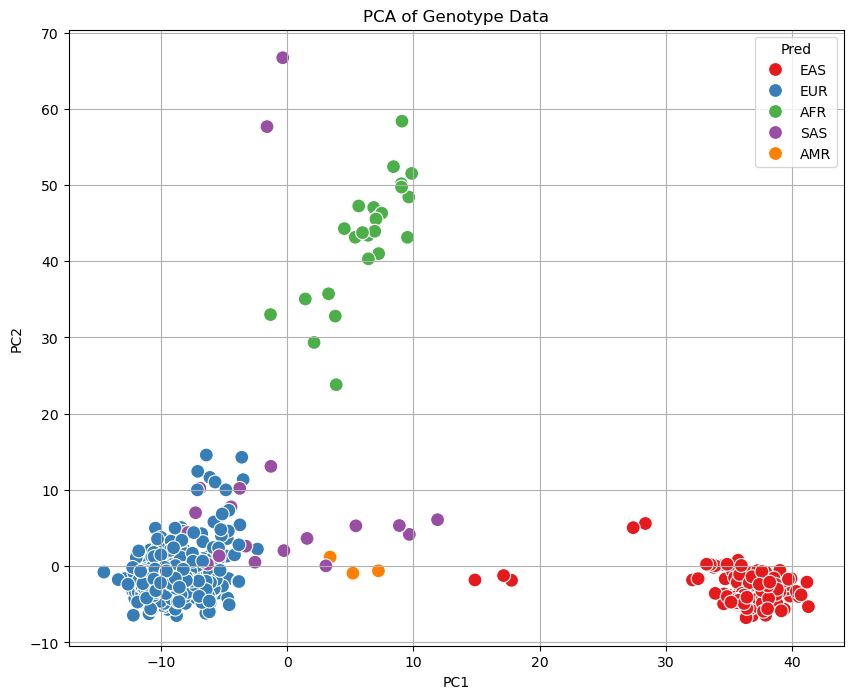

In [67]:
# List of specific sample IDs to highlight
highlight_ids = []


import seaborn as sns
import matplotlib.pyplot as plt

# Plot the PCA results with color labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Pred', data=merged_df, s=100, palette='Set1')

# Highlight specific IDs
for i, row in merged_df.iterrows():
    if row['Sample'] in highlight_ids:
        plt.text(row['PC1'] + 0.02, row['PC2'], row['Sample'], fontsize=9, color='black', weight='bold')
        plt.scatter(row['PC1'], row['PC2'], color='black', s=200, edgecolor='yellow', linewidth=2)  # Optional: Highlight with a larger marker

plt.title('PCA of Genotype Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


In [85]:
svm_preds.to_excel('Ancestry_Predictions_SVM.xlsx', index = None)